the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 58767.791910 from DATE-OBS.
Set MJD-END to 58767.957778 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 58767.838079 from DATE-OBS.
Set MJD-END to 58767.957778 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58767.375556 from DATE-OBS.
Set MJD-END to 58767.957789 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58767.375556 from DATE-OBS.
Set MJD-END to 58767.957778 from DATE-END'. [astropy.wcs.wcs]


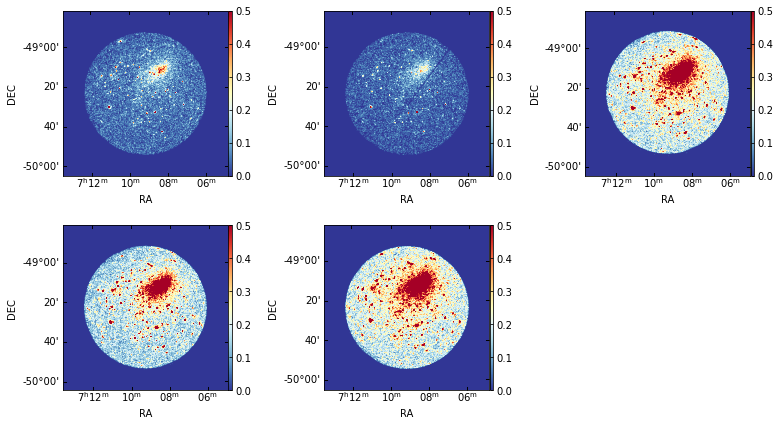

In [3]:
import os
import pylab as pl 
import numpy as np
import matplotlib as mpl
from astropy.io import fits
from astropy.wcs import WCS
from scipy import interpolate
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
from astropy.cosmology import WMAP9 as cosmo
from astropy.visualization import PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize, simple_norm
from astropy.visualization import PercentileInterval 
mpl.rc('xtick',direction='in') 
from matplotlib.patches import Ellipse
mpl.rc('xtick',direction='in') 
mpl.rc('ytick',direction='in') 
mpl.rcParams['contour.negative_linestyle'] = 'solid' 
plt.rc('font',family='sans-serif',serif='Helvetica',size=11) 
params = {'text.usetex': False, 'mathtext.fontset': 'cm', 'mathtext.default': 'regular'} 
plt.rcParams.update(params) 
mpl.rcParams['figure.dpi'] = 150
%matplotlib inline


w_dir = !pwd

observations = [ x for x 
                            in sorted(os.listdir('data/full_eband/')) if '.fits' in x ]


fig = pl.gcf()
nrows = 3
ncols = 3
fig.set_size_inches(6, 6)

for i in range(len(observations)):
    # Set up subplot; subplot indices start at 1
    phot_image = fits.open(w_dir[0]+'/data/full_eband/'+observations[i])
    #f_eband_lc = fits.open(w_dir[0]+'/light_curves/'+new_curves[i]) #filtered

    sp = pl.subplot(nrows, ncols, i + 1, projection=WCS(phot_image[0].header))
    pl.imshow(phot_image[0].data, origin='lower', vmax=0.5, cmap='RdYlBu_r')
    pl.colorbar(aspect=50, pad=.002, fraction=.0196)
    pl.xlabel('RA')
    pl.ylabel('DEC')


    #if i > 2 : pl.xlabel('time (ks)', fontsize = 14)
    #if i == 0 or i == 3 : pl.ylabel(r'$\rm rate\ (cts/s/deg^2)$', fontsize = 14)

pl.subplots_adjust(right=1.8, top = 1.5, wspace=0.3, hspace=0.3)
#pl.savefig('light_curves.pdf', dpi=150, bbox_inches='tight')
plt.show()

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 58767.375556 from DATE-OBS.
Set MJD-END to 58767.957789 from DATE-END'. [astropy.wcs.wcs]
/Users/xola/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:139: RuntimeWarning: divide by zero encountered in true_divide
/Users/xola/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:139: RuntimeWarning: invalid value encountered in true_divide


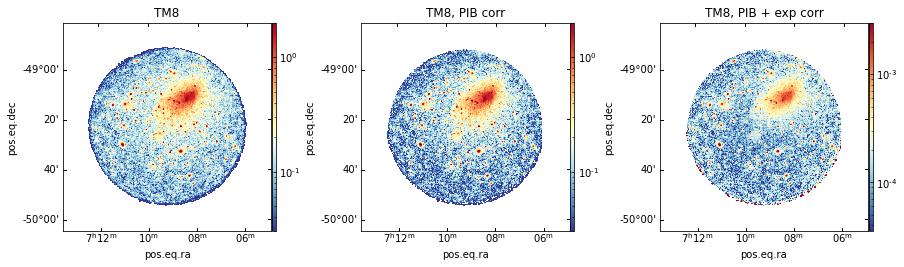

In [7]:
observations = [ x for x 
                            in sorted(os.listdir('data/full_eband/')) if '.fits' in x ]
TMs = [1, 2, 6]

TM8, TM9 = 0, 0
PIB_map_TM8, PIB_map_TM9 = 0, 0


'''
reading fwc spectra 
and rmf
'''

fwc_rmf = [ x for x 
                in sorted(os.listdir('data/fwc/bkg_spec/')) if 'RMF' in x ]

fwc_source_spec = [ x for x 
                    in sorted(os.listdir('data/fwc/source_spec/')) if '.fits' in x ]

'''
loading spectra 
and rmf for observations
'''


'''
for each TM
'''

nonvign_TM8 = fits.open('data/expmaps/TM8_nonvignexpmap.fits')
TM8_photon_image = fits.open('data/filtered_ev/TM8_filtered_ev.fits')

FWC_TM8_sourcespec, FWC_TM8_bkspec = 0, 0

obs_TM8_sourcespec, obs_TM8_bkspec = 0, 0
bgsub_TM8 = 0


for i in range(len(TMs)):

    nonv_exmap = fits.open( 
                                w_dir[0]+'/data/expmaps/nonvignetted_TM'+str(TMs[i])+'.fits' )
    vign_exmap = fits.open(
                            w_dir[0]+'/data/expmaps/vignetted_TM'+str(TMs[i])+'.fits' )

    obs = fits.open(
                        w_dir[0]+'/data/full_eband/reduced_TM'+str(TMs[i])+'.fits' )

    photon_image = fits.open(
                        w_dir[0]+'/data/filtered_ev/filtered_TM'+str(TMs[i])+'.fits' )

    events = obs['EVENTS'].data

    # Extract the TIME and PI columns (assuming PI represents energy in eV)
    times = events['TIME']
    energies = events['PI']

    # Extract the GTIs
    gti = obs['FLAREGTI'+str(TMs[i])].data

    # Define the energy range (in keV, convert to eV if necessary)
    energy_min = 6000   # lower bound in eV
    energy_max = 9000  # upper bound in eV

    # Filter events based on the energy range
    sband_emask = ( energies >= 300 ) & \
                                        ( energies <= 2000 ) 

    hband_emask = ( energies >= 6000) & \
                                        ( energies <= 9000 )
    filtered_times = times[hband_emask]

    # Calculate total exposure time from GTIs
    total_exposure_time = np.sum(gti['STOP'] - gti['START'])
    
    H_obs = len(filtered_times)    #total number of counts in this band

    '''
    filter wheel closed 
    observations
    '''

    rmf_data = fits.open( 
                            w_dir[0]+'/data/fwc/bkg_spec/'+'pc00TM'+str(TMs[i])+\
                                    '_FWC1.0_'+str(TMs[i])+'00_RMF_c946.fits')['EBOUNDS'].data

    src_spec = fits.open( 
                            w_dir[0]+'/data/fwc/source_spec/'+'TM'+str(TMs[i])+\
                                '_FWC_c010_'+str(TMs[i])+'20_SourceSpec_pat15.fits' )['SPECTRUM'].data

    backg_spec = fits.open( 
                        w_dir[0]+'/data/fwc/bkg_spec/'+'pc00TM'+str(TMs[i])+\
                                    '_FWC1.0_'+str(TMs[i])+'00_BackgrSpec_c946.fits' )['SPECTRUM'].data
    
    fwc_energies = ( rmf_data['E_MIN'] + rmf_data['E_MAX'] )/2

    fwc_hband_mask = ((fwc_energies >= 6.) &\
                                            (fwc_energies <= 9.) )
    
    fwc_sband_mask = ((fwc_energies >= .3) &\
                                            (fwc_energies <= 2.) )

    FWC_TM8_sourcespec += src_spec['COUNTS'] 
    FWC_TM8_bkspec+= backg_spec['COUNTS']

    bgsub_TM8+=FWC_TM8_sourcespec[fwc_hband_mask]

    h_pib = FWC_TM8_sourcespec[fwc_hband_mask] #- FWC_TM8_bkspec[fwc_hband_mask]
    s_pib = FWC_TM8_sourcespec[fwc_sband_mask] #- FWC_TM8_bkspec[fwc_sband_mask]

    R = np.sum(s_pib)/np.sum(h_pib)

    '''
    creating a background map
    '''

    weighted_expmap_TM8 = nonv_exmap[0].data/7

    TM8_PIB_map = (weighted_expmap_TM8/np.sum(weighted_expmap_TM8))*H_obs*R

'''
plotting 
'''


vgn_TM8 = fits.open('data/expmaps/TM8_vignexpmap.fits')

pl.subplot(131, projection=WCS(TM8_photon_image[0].header), title='TM8')
pl.imshow(TM8_photon_image[0].data, origin='lower', norm = LogNorm(vmin=0.03, vmax=2), cmap='RdYlBu_r')
pl.colorbar(aspect=50, pad=.002, fraction=.0196)


bg_subtracted = TM8_photon_image[0].data - TM8_PIB_map

bg_subtracted[ 
                np.where(bg_subtracted == 0) ] = np.nan

pl.subplot(132, projection = WCS(TM8_photon_image[0].header), title='TM8, PIB corr')
pl.imshow(bg_subtracted, origin='lower',norm = LogNorm(vmin=0.03, vmax=2), cmap='RdYlBu_r')
pl.colorbar(aspect=50, pad=.002, fraction=.0196)


exposure_corrected = (TM8_photon_image[0].data - TM8_PIB_map)/(vgn_TM8[0].data/7)
exposure_corrected[ 
                    np.where(exposure_corrected == 0) ] = np.nan
pl.subplot(133, projection=WCS(TM8_photon_image[0].header), title='TM8, PIB + exp corr')

pl.imshow(exposure_corrected, origin='lower', norm= LogNorm(vmin=0.000035, vmax=0.003), cmap='RdYlBu_r')
pl.colorbar(aspect=50, pad=.002, fraction=.0196)

pl.subplots_adjust(right=2., top=2, wspace=0.4)


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 58767.375556 from DATE-OBS.
Set MJD-END to 58767.957789 from DATE-END'. [astropy.wcs.wcs]
/Users/xola/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:110: RuntimeWarning: divide by zero encountered in true_divide
/Users/xola/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:110: RuntimeWarning: invalid value encountered in true_divide


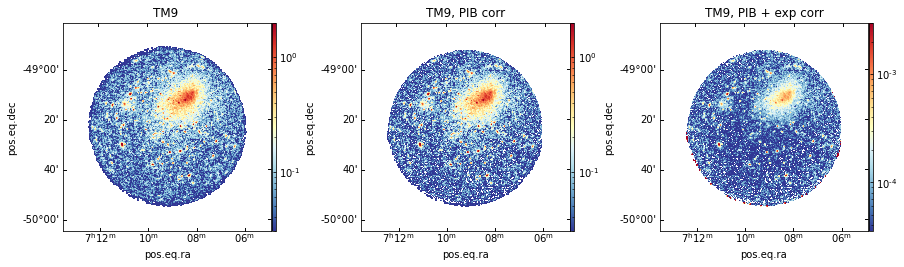

In [9]:
observations = [ x for x 
                            in sorted(os.listdir('data/full_eband/')) if '.fits' in x ]
TMs = [5, 7]

'''
for each TM
'''

nonvign_TM9 = fits.open('data/expmaps/TM9_nonvignexpmap.fits')
TM9_photon_image = fits.open('data/filtered_ev/TM9_filtered_ev.fits')

FWC_TM9_sourcespec, FWC_TM9_bkspec = 0, 0

obs_TM9_sourcespec, obs_TM9_bkspec = 0, 0
bgsub_TM9 = 0

for i in range(len(TMs)):

    nonv_exmap = fits.open( 
                                w_dir[0]+'/data/expmaps/nonvignetted_TM'+str(TMs[i])+'.fits' )
    vign_exmap = fits.open(
                            w_dir[0]+'/data/expmaps/vignetted_TM'+str(TMs[i])+'.fits' )

    obs = fits.open(
                        w_dir[0]+'/data/full_eband/reduced_TM'+str(TMs[i])+'.fits' )

    events = obs['EVENTS'].data

    # Extract the TIME and PI columns (assuming PI represents energy in eV)
    times = events['TIME']
    energies = events['PI']

    # Extract the GTIs
    gti = obs['FLAREGTI'+str(TMs[i])].data

    # Define the energy range (in keV, convert to eV if necessary)
    energy_min = 6000   # lower bound in eV
    energy_max = 9000  # upper bound in eV

    # Filter events based on the energy range
    hband_emask = ( energies >= 6000) & \
                                        ( energies <= 9000 )
    filtered_times = times[hband_emask]

    # Calculate total exposure time from GTIs
    total_exposure_time = np.sum(gti['STOP'] - gti['START'])
    
    H_obs = len(filtered_times)    #total number of counts in this band
    
    '''
    filter wheel closed 
    observations
    '''

    rmf_data = fits.open( 
                            w_dir[0]+'/data/fwc/bkg_spec/'+'pc00TM'+str(TMs[i])+\
                                    '_FWC1.0_'+str(TMs[i])+'00_RMF_c946.fits')['EBOUNDS'].data

    src_spec = fits.open( 
                            w_dir[0]+'/data/fwc/source_spec/'+'TM'+str(TMs[i])+\
                                '_FWC_c010_'+str(TMs[i])+'20_SourceSpec_pat15.fits' )['SPECTRUM'].data

    backg_spec = fits.open( 
                        w_dir[0]+'/data/fwc/bkg_spec/'+'pc00TM'+str(TMs[i])+\
                                    '_FWC1.0_'+str(TMs[i])+'00_BackgrSpec_c946.fits' )['SPECTRUM'].data
    
    fwc_energies = ( rmf_data['E_MIN'] + rmf_data['E_MAX'] )/2

    fwc_hband_mask = ((fwc_energies >= 6.) &\
                                            (fwc_energies <= 9.) )
    
    fwc_sband_mask = ((fwc_energies >= 1.) &\
                                            (fwc_energies <= 2.) )

    FWC_TM9_sourcespec+= src_spec['COUNTS']
    FWC_TM9_bkspec+= backg_spec['COUNTS']
    bgsub_TM9 += FWC_TM9_sourcespec[fwc_hband_mask]
    
    h_pib = FWC_TM9_sourcespec[fwc_hband_mask] #- FWC_TM9_bkspec[fwc_hband_mask]
    s_pib = FWC_TM9_sourcespec[fwc_sband_mask] #- FWC_TM9_bkspec[fwc_sband_mask]

    R = np.sum(s_pib)/np.sum(h_pib)

    '''
    creating a background map
    '''

    weighted_expmap_TM9 = nonv_exmap[0].data/7

    TM9_PIB_map = (weighted_expmap_TM9/np.sum(weighted_expmap_TM9))*H_obs*R
'''
plotting 
'''

vgn_TM9 = fits.open('data/expmaps/TM9_vignexpmap.fits')


pl.subplot(131, projection=WCS(TM9_photon_image[0].header), title='TM9 ')
pl.imshow(TM9_photon_image[0].data, origin='lower', norm = LogNorm(vmin=0.03, vmax=2), cmap='RdYlBu_r')
pl.colorbar(aspect=50, pad=.002, fraction=.0196)


bg_subtracted = TM9_photon_image[0].data - TM9_PIB_map

bg_subtracted[ 
                np.where(bg_subtracted == 0) ] = np.nan

pl.subplot(132, projection = WCS(TM9_photon_image[0].header) , title='TM9, PIB corr')
pl.imshow(bg_subtracted, origin='lower', norm = LogNorm(vmin=0.03, vmax=2), cmap='RdYlBu_r')
pl.colorbar(aspect=50, pad=.002, fraction=.0196)


exposure_corrected = (TM9_photon_image[0].data - TM9_PIB_map)/(vgn_TM9[0].data/7)
exposure_corrected[ 
                    np.where(exposure_corrected == 0) ] = np.nan
pl.subplot(133, projection=WCS(TM9_photon_image[0].header), title='TM9, PIB + exp corr')

pl.imshow(exposure_corrected, origin='lower', norm= LogNorm(vmin=0.000035, vmax=0.003), cmap='RdYlBu_r')
pl.colorbar(aspect=50, pad=.002, fraction=.0196)

pl.subplots_adjust(right=2., top=2, wspace=0.4)


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 58767.375556 from DATE-OBS.
Set MJD-END to 58767.957789 from DATE-END'. [astropy.wcs.wcs]
/Users/xola/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide


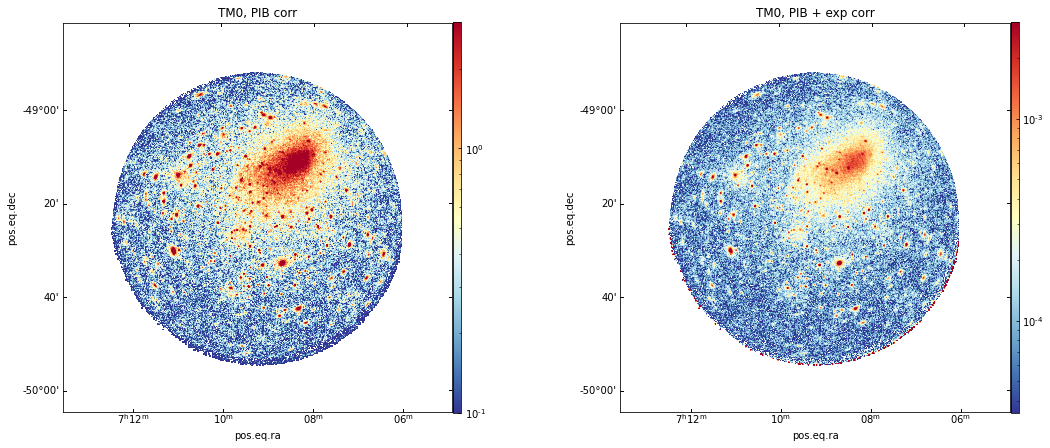

In [38]:

fig, ax = pl.subplots(ncols = 2, nrows = 1, figsize=(9, 9))

'''
PIB subtraction on the total map
'''

combined_PIB_map = TM8_PIB_map + TM9_PIB_map
TM0 = fits.open('data/filtered_ev/TM0_filtered_ev.fits')

PIB_subtracted_TM0 = TM0[0].data - combined_PIB_map            #total photon image corrected for PIB

PIB_subtracted_TM0[ 
                np.where( PIB_subtracted_TM0 == 0 ) ] = np.nan

ax0 = pl.subplot(121, projection=WCS(TM0[0].header), title='TM0, PIB corr')
img = ax0.imshow(PIB_subtracted_TM0, origin='lower', norm= LogNorm(vmin=0.1, vmax=3.), cmap='RdYlBu_r')
cb = pl.colorbar(img, ax = ax0, aspect = 50, pad = .002, fraction = .0196)

'''
exposure correction
'''

corr = np.sum(TM9_photon_image[0].data - TM9_PIB_map) / np.sum(TM8_photon_image[0].data - TM8_PIB_map)

vgn_TM8 = fits.open(
                        'data/expmaps/TM8_nonvignexpmap.fits' )  #vignetted TM8 exp map
vgn_TM9 = fits.open(
                        'data/expmaps/TM9_nonvignexpmap.fits' )  #vignetted TM9 exp map

exp0 = (vgn_TM8[0].data + corr*vgn_TM9[0].data) / 7    #weighting the vignetted total expmap i.e. TM0


exp_corr_TM0 = PIB_subtracted_TM0 / exp0

exp_corr_TM0[ 
                np.where( exp_corr_TM0 == 0 ) ] = np.nan

ax1 = pl.subplot(122, projection=WCS(TM0[0].header), title='TM0, PIB + exp corr')
img = ax1.imshow(exp_corr_TM0, origin='lower', norm= LogNorm(vmin=0.000035, vmax=0.003), cmap='RdYlBu_r')
cb = pl.colorbar(img, ax = ax1, aspect = 50, pad = .002, fraction = .0196)

pl.subplots_adjust(right = 1.6, top = 1.7, wspace=0.4)
pl.show()

'''
writing the combined
image to fits
'''
tm0_hdr = TM8_photon_image[0].header + TM9_photon_image[0].header
tm0_exphdr, tm0_expimag = vgn_TM8[0].header + vgn_TM9[0].header, vgn_TM8[0].data + vgn_TM9[0].data



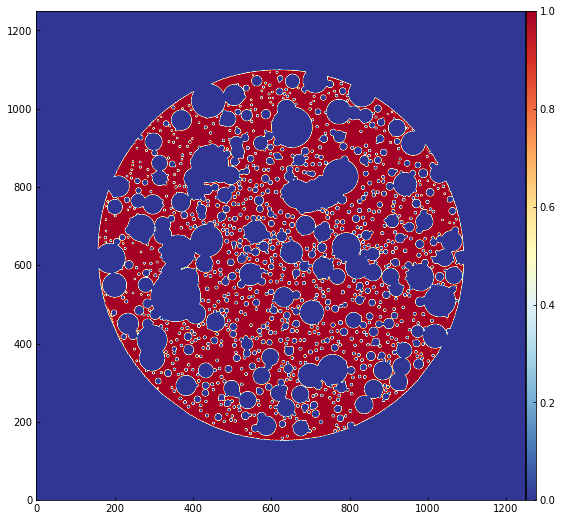

In [72]:
cheese = fits.open('data/cheese_mask.fits')
fig, ax = pl.subplots(ncols = 1, nrows = 1, figsize=(9, 9))
pl.imshow(cheese[0].data, origin='lower', cmap='RdYlBu_r')
pl.colorbar(aspect = 50, pad = .002, fraction = .0196)

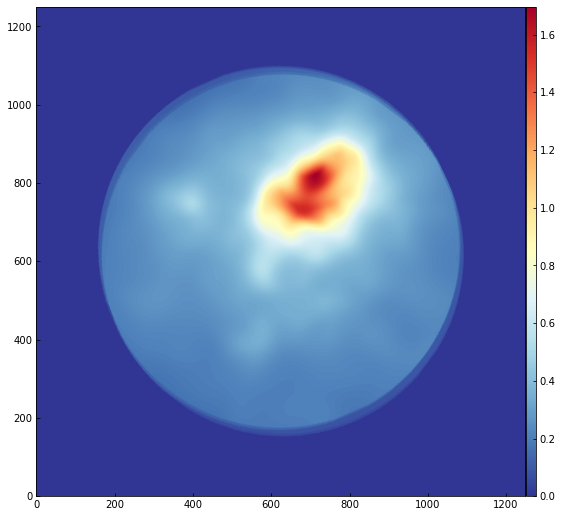

In [71]:
bk = fits.open('data/backG_image.fits')
fig, ax = pl.subplots(ncols = 1, nrows = 1, figsize=(9, 9))

pl.imshow(bk[0].data, origin='lower', cmap='RdYlBu_r')
pl.colorbar(aspect = 50, pad = .002, fraction = .0196)

In [39]:
'''
writing science images
of TM8 & 9 for erbox
'''

vgn_TM0 = fits.open('data/expmaps/TM0_vignexpmap.fits')

fits.writeto('data/science_imgs/TM0_science_image.fits', TM0[0].data, TM0[0].header, overwrite=True)
fits.writeto('data/science_imgs/expmap_TM0_image.fits',  vgn_TM0[0].data, vgn_TM0[0].header, overwrite=True)



In [40]:
ee = fits.open('data/science_imgs/expmap_TM0_image.fits')

ee.info()

Filename: data/science_imgs/expmap_TM0_image.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     109   (1250, 1250)   float32   


In [ ]:
import sep

exposure_corrected[np.where(np.isnan(exposure_corrected) == True)] = 0


bkg = sep.Background(TM8_photon_image[0].data.byteswap().newbyteorder())

bkg_image = bkg.back()

pl.imshow(bkg_image,  cmap='gray', origin='lower')
pl.colorbar(aspect = 50, pad = .002, fraction = .0196)
pl.show()

bkg_rms = bkg.rms()
pl.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
pl.colorbar(aspect = 50, pad = .002, fraction = .0196)


In [ ]:
data_sub = TM8_photon_image[0].data - bkg

objects = sep.extract(data_sub, 5.5, err=bkg.globalrms)

In [ ]:
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = [10., 10.]

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='RdYlBu_r',
               vmin=0, vmax=5, origin='lower')
pl.colorbar(im, aspect = 50, pad = .002, fraction = .0196)
# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('white')
    ax.add_artist(e)
pl.savefig('source_finding.pdf', dpi=200, bbox_inches='tight')

In [ ]:
import numpy as np
from astropy.io import fits

# Load your 2D array image (replace 'erosita_image.fits' with your file)
image_path = 'total_maps/filtered_TM8.fits'
with fits.open(image_path) as hdul:
    image_data = hdul[0].data

# Check if the image was loaded properly
if image_data is None:
    raise ValueError("Image not found or path is incorrect")

import pywt

def wavelet_filtering(image, wavelet='haar', level=2, threshold=20):
    coeffs = pywt.wavedec2(image, wavelet, level=level)
    cA, (cH, cV, cD) = coeffs[0], coeffs[1]
    def thresholding(coeffs, threshold):
        return [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
    cH = thresholding(cH, threshold)
    cV = thresholding(cV, threshold)
    cD = thresholding(cD, threshold)
    coeffs[1] = (cH, cV, cD)
    filtered_image = pywt.waverec2(coeffs, wavelet)
    filtered_image = np.clip(filtered_image, 0, np.max(filtered_image))
    return filtered_image

filtered_image = wavelet_filtering(image_data)


In [ ]:
import sep

from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = [10., 10.]

# Extract background and subtract it
background = sep.Background(filtered_image.data.byteswap().newbyteorder())
background_subtracted = filtered_image - background

# Extract sources
objects = sep.extract(background_subtracted, thresh=1.5, minarea=5)

m, s = np.mean(background_subtracted), np.std(background_subtracted)
im = ax.imshow(filtered_image, cmap='RdYlBu_r',
               origin='lower')
cb = pl.colorbar(im, ax=ax)
# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=objects['a'][i],
                height=objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
#pl.savefig('source_finding.pdf', dpi=200, bbox_inches='tight')


In [ ]:
import numpy as np
import sep
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from astropy.io import fits

# Load the image data (replace 'erosita_image.fits' with your file)
image_path = 'total_maps/filtered_TM8.fits'
with fits.open(image_path) as hdul:
    image_data = hdul[0].data

# Check if the image was loaded properly
if image_data is None:
    raise ValueError("Image not found or path is incorrect")

# Perform wavelet filtering if needed (optional)
import pywt

def wavelet_filtering(image, wavelet='haar', level=2, threshold=20):
    coeffs = pywt.wavedec2(image, wavelet, level=level)
    cA, (cH, cV, cD) = coeffs[0], coeffs[1]
    def thresholding(coeffs, threshold):
        return [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
    cH = thresholding(cH, threshold)
    cV = thresholding(cV, threshold)
    cD = thresholding(cD, threshold)
    coeffs[1] = (cH, cV, cD)
    filtered_image = pywt.waverec2(coeffs, wavelet)
    filtered_image = np.clip(filtered_image, 0, np.max(filtered_image))
    return filtered_image

filtered_image = wavelet_filtering(image_data)

# For simplicity, we'll use the original image_data for this example

# Extract background and subtract it
background = sep.Background(filtered_image)
background_subtracted = filtered_image - background

# Extract sources
objects = sep.extract(background_subtracted, thresh=1.5, minarea=5)

# Plot the image
fig, ax = plt.subplots()
m, s = np.mean(filtered_image), np.std(filtered_image)
im = ax.imshow(filtered_image, cmap='RdYlBu_r', vmin=0, vmax=3, origin='lower')
cb = pl.colorbar(im, ax=ax, aspect = 50, pad = .002, fraction = .0196)

# Plot ellipses for each object
for obj in objects:
    e = Ellipse(xy=(obj['x'], obj['y']),
                width=6*obj['a'],  # 6 times the semi-major axis
                height=6*obj['b'],  # 6 times the semi-minor axis
                angle=obj['theta']*180.0/np.pi,  # Convert to degrees
                edgecolor='red', facecolor='none', lw=1.5)
    ax.add_patch(e)

plt.show()

In [ ]:
from astropy.table import Table

# Create a table from the extracted objects
catalog = Table(objects)

# Save the table to a FITS file
catalog.write('source_catalog.fits', format='fits', overwrite=True)

In [ ]:
import numpy as np
import sep
import matplotlib.pyplot as plt
from astropy.io import fits

# Load the image data (replace 'erosita_image.fits' with your file)
image_path = 'total_maps/filtered_TM8.fits'
with fits.open(image_path) as hdul:
    image_data = hdul[0].data

# Perform wavelet filtering if needed (optional)
def wavelet_filtering(image, wavelet='haar', level=2, threshold=20):
    coeffs = pywt.wavedec2(image, wavelet, level=level)
    cA, (cH, cV, cD) = coeffs[0], coeffs[1]
    def thresholding(coeffs, threshold):
        return [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
    cH = thresholding(cH, threshold)
    cV = thresholding(cV, threshold)
    cD = thresholding(cD, threshold)
    coeffs[1] = (cH, cV, cD)
    filtered_image = pywt.waverec2(coeffs, wavelet)
    filtered_image = np.clip(filtered_image, 0, np.max(filtered_image))
    return filtered_image

filtered_image = wavelet_filtering(image_data)

# For simplicity, we'll use the original image_data for this example

# Extract background and subtract it
background = sep.Background(filtered_image)
background_subtracted = filtered_image - background

# Extract sources
objects = sep.extract(background_subtracted, thresh=1.5, minarea=5)

# Create a mask with the same shape as the image, initialized to False
mask = np.zeros_like(filtered_image, dtype=bool)

# Mask the regions of the detected sources
for obj in objects:
    y, x = np.ogrid[:filtered_image.shape[0], :filtered_image.shape[1]]
    xc, yc = obj['x'], obj['y']
    a, b, theta = obj['a'], obj['b'], obj['theta']
    
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    
    x_ = (x - xc) * cos_theta + (y - yc) * sin_theta
    y_ = (y - yc) * cos_theta - (x - xc) * sin_theta
    
    # Ellipse equation
    mask_ellipse = ((x_**2 / (6*a)**2) + (y_**2 / (6*b)**2)) <= 1
    mask |= mask_ellipse

# Excise the sources by setting the masked areas to the median background level or zero
excised_image = np.copy(filtered_image)
excised_image[mask] = np.median(filtered_image[~mask])

# Plot the original and excised images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Original image
m, s = np.mean(filtered_image), np.std(filtered_image)
im1 = ax1.imshow(filtered_image, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
ax1.set_title('Original Image')

# Excised image
im2 = ax2.imshow(excised_image, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
ax2.set_title('Excised Image')

plt.show()

In [ ]:
tm0 = fits.open('trial/combined_TMs.fits')
tm0.info()

In [ ]:
pl.imshow(tm0[0].data, origin='lower', norm= LogNorm(vmin=0.1, vmax=3.), cmap='RdYlBu_r')
pl.colorbar(aspect = 50, pad = .002, fraction = .0196)

In [ ]:
fig, ax = pl.subplots(ncols = 2, nrows = 1, figsize=(9, 9))

'''
PIB subtraction on the total map
'''

combined_PIB_map = TM8_PIB_map + TM9_PIB_map
TM0 = fits.open('trial/combined_TMs.fits')
data = TM0[0].data
PIB_subtracted_TM0 = data - combined_PIB_map            #total photon image corrected for PIB

PIB_subtracted_TM0[ 
                np.where( PIB_subtracted_TM0 == 0 ) ] = np.nan

ax0 = pl.subplot(121, projection=WCS(TM0[0].header), title='TM0, PIB corr')
img = ax0.imshow(PIB_subtracted_TM0, origin='lower', norm= LogNorm(vmin=0.1, vmax=3.), cmap='RdYlBu_r')
cb = pl.colorbar(img, ax = ax0, aspect = 50, pad = .002, fraction = .0196)

'''
exposure correction
'''

corr = np.sum(TM9_photon_image[0].data - TM9_PIB_map) / np.sum(TM8_photon_image[0].data - TM8_PIB_map)

vgn_TM8 = fits.open(
                        'combined_expmaps/vignetted_TM8.fits' )  #vignetted TM8 exp map
vgn_TM9 = fits.open(
                        'combined_expmaps/vignetted_TM9.fits' )  #vignetted TM9 exp map

exp0 = (vgn_TM8[0].data + corr*vgn_TM9[0].data) / 7    #weighting the vignetted total expmap i.e. TM0


exp_corr_TM0 = PIB_subtracted_TM0 / exp0

exp_corr_TM0[ 
                np.where( exp_corr_TM0 == 0 ) ] = np.nan

ax1 = pl.subplot(122, projection=WCS(TM8_photon_image[0].header), title='TM0, PIB + exp corr')
img = ax1.imshow(exp_corr_TM0, origin='lower', norm= LogNorm(vmin=0.000035, vmax=0.003), cmap='RdYlBu_r')
cb = pl.colorbar(img, ax = ax1, aspect = 50, pad = .002, fraction = .0196)

pl.subplots_adjust(right = 1.6, top = 1.7, wspace=0.4)
pl.savefig('tm0.pdf', dpi = 150, bbox_inches='tight')
pl.show()



In [ ]:
rr = fits.open('expmaps/expmap_TM0.fits')

fits.writeto('expmaps/TM0_expimage.fits', rr[0].data, rr[0].header, overwrite=True)

In [ ]:
ff = fits.open('expmaps/TM0_expimage.fits')

ff.info()

pl.imshow(ff[0].data)


In [ ]:
d = fits.open('total_maps/TM0_fully_corrected_image.fits')

data = d[0].data

data[np.where(np.isnan(data) == True)] = 0

fits.writeto('total_maps/TM0_fully_corrected_image.fits', TM8_photon_image[0].data.astype(float), d[0].header, overwrite=True)

In [ ]:
d = fits.open('total_maps/TM0_fully_corrected_image.fits')

pl.imshow(d[0].data, origin='lower', vmax=5 )
pl.colorbar()

In [ ]:
d.info()

In [ ]:
tm_1 = fits.open('filtered_ev/filtered_TM1.fits')

hrd = tm_1[0].header
data = tm_1[0].data
fits.writeto('erbox_out/trial_scimage.fits', data, hrd, overwrite=True)

In [ ]:
tm_1 = fits.open('expmaps/vignetted_TM1.fits')

hrd = tm_1[0].header
data = tm_1[0].data
fits.writeto('erbox_out/exp_scimage.fits', data, hrd, overwrite=True)

In [ ]:
rr = fits.open('total_maps/TM0_fully_corrected_image.fits')

In [ ]:
rr.info()